<a href="https://colab.research.google.com/github/mohamedchnafy-ds/python_project/blob/main/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import libraries

In this section, we will import all the libraries required for the project. The first library, **google.colab**, is used to specify the drive mounting process. we import various libraries required for the project: **pandas** for data manipulation, **numpy** for numerical operations, **sqlalchemy** and **sqlite3** for database interactions, **psycopg2** for PostgreSQL connections, **plotly** and **matplotlib** for data visualization, and **os** for file and directory management.

> Ajouter une citation



In [4]:
# Importing the necessary library to mount Google Drive in Colab
from google.colab import drive

# Mounting Google Drive to access files stored in it
drive.mount('/content/drive')

# The following lines are commented out but would change the working directory to the specified folder in Google Drive
# %cd '/content/drive/MyDrive/python project/notebooks'
# os.chdir('/content/drive/MyDrive/python project/notebooks')

# Importing commonly used libraries for data analysis and manipulation
import pandas as pd  # Library for data manipulation using DataFrames
import numpy as np   # Library for numerical operations, such as arrays and matrix calculations

# Importing SQLAlchemy for database interactions
import sqlalchemy as db  # Core library for working with relational databases
from sqlalchemy import create_engine  # Function to create a connection to the database

# Importing SQLite library to interact with SQLite databases
import sqlite3  # SQLite module for working with SQLite databases

# Importing OS module to interact with the file system and manage directories
import os

# Importing psycopg2 to interact with PostgreSQL databases
import psycopg2  # PostgreSQL adapter for Python

# Importing quote_plus for URL encoding (commonly used for database connection strings)
from urllib.parse import quote_plus

# Importing Plotly for interactive data visualization
import plotly.express as px  # High-level interface for creating interactive charts
import plotly.io as pio  # Interface for managing Plotly figures and exporting

# Importing Matplotlib for creating static visualizations
from matplotlib import pyplot as plt  # Standard library for creating 2D graphs and plots

# Installing necessary packages (uncomment to install)
# !pip install -U --user --proxy http://irsrvpxw1-elv:8082 fsspec pip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 #### Data



There are two datasets:



1.   Norway Wellbores stored in a SQLite database (file: wells_data.db,table: wells_data).
2.   Volve production in an XLSX file with two sheets:


*   Daily Production Data
*   Monthly Production Data










    
    
        
        

In [6]:
# Changing the current working directory to the specified folder in Google Drive
os.chdir('/content/drive/MyDrive/python project/')

# Getting the absolute path of the current working directory
current_dir = os.path.abspath(os.getcwd())

# Printing the absolute path of the current directory
current_dir


'/content/drive/MyDrive/python project'

In [7]:
# Creating a path by appending '/input_data/' to the current directory
path = current_dir + '/input_data/'


In [8]:
# Loading the Excel file from the specified path using pandas ExcelFile function
v_prod = pd.ExcelFile(path+'Volve_production_data.xlsx')

# Printing the names of the sheets available in the Excel file
print("Feuilles disponibles:", v_prod.sheet_names)

# Parsing the 'Daily Production Data' sheet from the Excel file into a DataFrame
daily = v_prod.parse('Daily Production Data')

# Parsing the 'Monthly Production Data' sheet from the Excel file into a DataFrame
monthly = v_prod.parse('Monthly Production Data')

# Displaying the 'Monthly Production Data' DataFrame
monthly


Feuilles disponibles: ['Daily Production Data', 'Monthly Production Data']


,Wellbore name,NPDCode,Year,Month,On Stream (hrs),Oil (Sm3),Gas (Sm3),Water (Sm3),GI (Sm3),WI (Sm3)
0,15/9-F-1 C,7405,2014,4,227.50000,11142.47,1597936.65,0.00,NaN,NaN
1,15/9-F-1 C,7405,2014,5,733.83334,24901.95,3496229.65,783.48,NaN,NaN
2,15/9-F-1 C,7405,2014,6,705.91666,19617.76,2886661.69,2068.48,NaN,NaN
3,15/9-F-1 C,7405,2014,7,742.41666,15085.68,2249365.75,6243.98,NaN,NaN
4,15/9-F-1 C,7405,2014,8,432.99166,6970.43,1048190.80,4529.75,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
521,15/9-F-5,5769,2016,5,732.00000,9724.40,1534677.16,3949.90,NaN,0.0
522,15/9-F-5,5769,2016,6,718.41667,9121.48,1468557.12,2376.93,NaN,NaN
523,15/9-F-5,5769,2016,7,668.64168,9985.29,1602674.39,2453.71,NaN,0.0
524,15/9-F-5,5769,2016,8,608.42500,8928.90,1417278.51,2371.86,NaN,0.0


In the Excel file, we can see that there are two available sheets: ['Daily Production Data', 'Monthly Production Data'], and we are interested in the **Monthly Production Data** sheet.

In [10]:
# Creating a connection to the SQLite database using SQLAlchemy
engine = create_engine('sqlite:///{}wells_data.db'.format(path))

# Listing all the tables in the SQLite database
with engine.connect() as conn:
    # Query to retrieve the names of all tables in the database
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    # Executing the query and storing the result in a pandas DataFrame
    tables = pd.read_sql_query(query, conn)
    # Converting the 'name' column (table names) into a list
    table_names = tables['name'].tolist()

# Printing the list of table names in the database
print("The file contains the following tables:: {}".format(table_names))


The file contains the following tables:: ['wells_data']


#### Conversion de la database en fichier excel

In [11]:
# Créer un writer Excel
with pd.ExcelWriter('/content/drive/MyDrive/python project/output_data/wells_data.xlsx', engine='openpyxl') as writer:
    # Pour chaque table dans la base de données
    for table_name in table_names:
        # Lire la table avec pandas
        df = pd.read_sql_table(table_name, engine)

        # Écrire chaque table dans une feuille différente de l'Excel
        df.to_excel(writer, sheet_name=table_name, index=False)

print("Conversion completed! The file output_data.xlsx has been created.")

Conversion completed! The file output_data.xlsx has been created.


#  local PostgreSQL database

In [14]:
# Configuration for PostgreSQL database connection parameters
db_params = {
    'host': 'localhost',        # Database host (localhost for local connection)
    'database': 'welldata',     # Name of the database
    'user': 'postgres',         # Username for PostgreSQL
    'password': 'postgres1',    # Password for PostgreSQL user
    'port': '5432'              # Default port for PostgreSQL
}

# Function to transfer data from an Excel file to a PostgreSQL database
def excel_to_postgresql(excel_file, table_name, if_exists='replace'):
    try:
        # Read the Excel file into a pandas DataFrame
        print(f"Reading Excel file: {excel_file}")
        df = pd.read_excel(excel_file)

        # Escape special characters in the password for URL encoding
        password = quote_plus(db_params['password'])
        # Create the PostgreSQL connection string using the provided parameters
        connection_string = f"postgresql://{db_params['user']}:{password}@{db_params['host']}:{db_params['port']}/{db_params['database']}"

        # Create the SQLAlchemy engine to establish a connection to the PostgreSQL database
        print("Connecting to PostgreSQL...")
        engine = create_engine(connection_string)

        # Transfer the data from the DataFrame to PostgreSQL
        print(f"Transferring data to the table: {table_name}")
        df.to_sql(
            name=table_name,          # Table name in PostgreSQL
            con=engine,               # Connection to the PostgreSQL engine
            if_exists=if_exists,      # 'replace' to overwrite, 'append' to add to the table
            index=False,              # Do not write DataFrame index to the database
            schema='public'           # Default schema in PostgreSQL
        )

        # Check the number of rows transferred
        with engine.connect() as conn:
            result = conn.execute(f"SELECT COUNT(*) FROM {table_name}")  # Query the row count
            count = result.scalar()  # Retrieve the scalar value (number of rows)

        # Print success message with the number of rows transferred
        print(f"Transfer successful! {count} rows transferred to {table_name}")
        return True

    except Exception as e:
        # Print error message if something goes wrong during the transfer
        print(f"Error during transfer: {str(e)}")
        return False

    finally:
        # Dispose of the engine to close the database connection
        if 'engine' in locals():
            engine.dispose()


In [15]:
# Utilisation de la fonction
if __name__ == "__main__":
    # Paramètres
    excel_file = '/content/drive/MyDrive/python project/output_data/wells_data.xlsx'  # Votre fichier Excel
    table_name = 'wells_data'        # Nom de la table dans PostgreSQL

    # Exécuter le transfert
    excel_to_postgresql(excel_file, table_name, if_exists='replace')

Reading Excel file: /content/drive/MyDrive/python project/output_data/wells_data.xlsx
Connecting to PostgreSQL...
Transferring data to the table: wells_data
Error during transfer: (psycopg2.OperationalError) connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (::1), port 5432 failed: Cannot assign requested address
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/20/e3q8)


# Wells Data

In [23]:
# Create a path to the 'wells_data.xlsx' file located in the 'output_data' directory
current_dir + '/output_data/'+'wells_data.xlsx'

# Load the Excel file into a pandas ExcelFile object
wells_data1 = pd.ExcelFile(current_dir + '/output_data/'+'wells_data.xlsx')

# Print the available sheet names in the Excel file
print("Available sheets:", wells_data1.sheet_names)

# Read the 'wells_data' sheet into a DataFrame after checking the sheet names
wells_data = wells_data1.parse('wells_data')

# Display the contents of the 'wells_data' DataFrame
wells_data


Available sheets: ['wells_data']


,index,wlbNpdidWellbore,dscNpdidDiscovery,fldNpdidField,fclNpdidFacilityDrilling,fclNpdidFacilityProducing,wlbNpdidWellboreReclass,prlNpdidProductionLicence,wlbWellboreName,wlbWell,...,wlbSubSea,wlbKickOffPoint,wlbLicenceTargetName,wlbPluggedDate,wlbPluggedAbandonDate,prlNpdidProdLicenceTarget,wlbNpdidSiteSurvey,wlbSiteSurvey,wlbDateReclass,wlbPointGeometryWKT
0,0,28,44990.0,NaN,288280.0,NaN,0,21348.0,7/8-3,7/8-3,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.5460499996279968 57.258494000193025)
1,1,30,NaN,NaN,287848.0,NaN,0,21356.0,7/11-8,7/11-8,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.5295830008933171 57.213871999628537)
2,2,42,44966.0,43792.0,287956.0,NaN,0,21356.0,7/11-5,7/11-5,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.4982029996618897 57.135107999856238)
3,3,57,23296230.0,43785.0,271693.0,NaN,0,20900.0,7/11-7,7/11-7,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.4346719996169637 57.069455999904839)
4,4,149,44960.0,43785.0,296407.0,NaN,0,20900.0,7/11-1,7/11-1,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,POINT (2.4401110006239985 57.070999999716726)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,8243,5743,NaN,NaN,289441.0,NaN,0,2490623.0,25/10-U-3,25/10-U-3,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN
8244,8244,7685,NaN,NaN,373521.0,NaN,0,21559610.0,6306/5-U-1,6306/5-U-1,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN
8245,8245,7810,NaN,NaN,289441.0,NaN,0,NaN,7934/6-U-3,7934/6-U-3,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN
8246,8246,8412,NaN,NaN,461030.0,NaN,0,28942014.0,2/6-U-1,2/6-U-1,...,NO,0,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN


# Well Parameters Analysis: Temperature, Drilling Duration, and Depth Distribution by Formation Ag

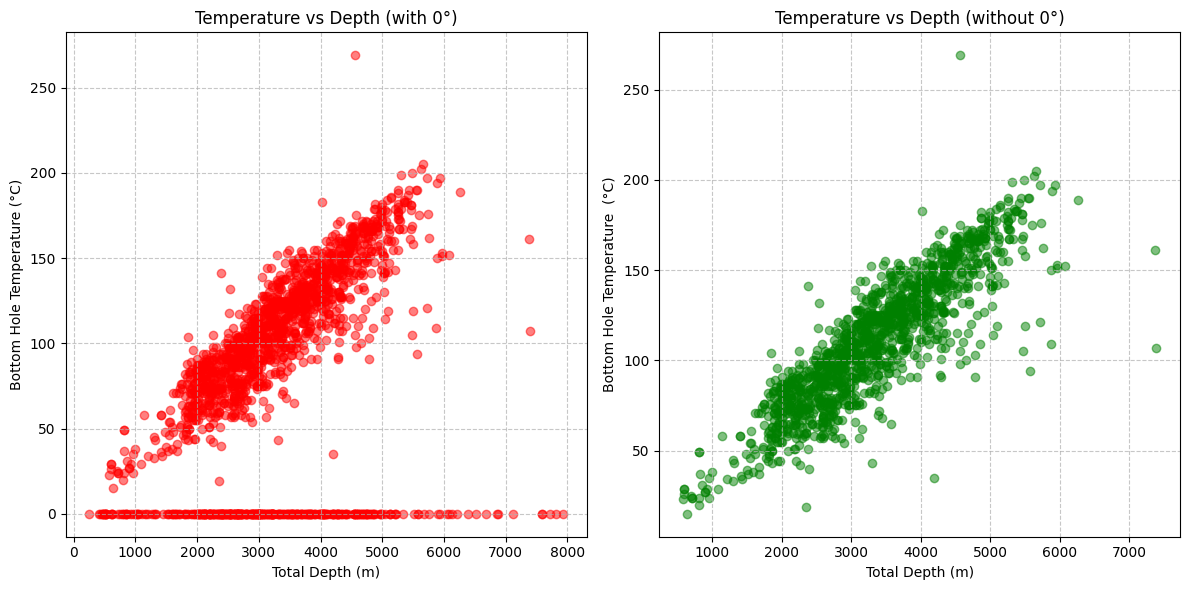

In [29]:
# Table for wlbBottomHoleTemperature without 0 degrees
wells_data_without_0 = wells_data[wells_data['wlbBottomHoleTemperature'] > 0]
# Create a figure with two subplots side by side (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First scatter plot (with 0° included)
ax1.scatter(wells_data['wlbTotalDepth'],  # X-axis: Total Depth
            wells_data['wlbBottomHoleTemperature'],  # Y-axis: Bottom Hole Temperature
            alpha=0.5,  # Transparency of points
            color='red')  # Color of points
ax1.set_xlabel('Total Depth (m)')  # X-axis label
ax1.set_ylabel('Bottom Hole Temperature (°C)')  # Y-axis label
ax1.set_title('Temperature vs Depth (with 0°)')  # Plot title
ax1.grid(True, linestyle='--', alpha=0.7)  # Grid with dashed lines and some transparency

# Second scatter plot (without 0°)
ax2.scatter(wells_data_without_0['wlbTotalDepth'],  # X-axis: Total Depth
            wells_data_without_0['wlbBottomHoleTemperature'],  # Y-axis: Bottom Hole Temperature
            alpha=0.5,  # Transparency of points
            color='green')  # Color of points
ax2.set_xlabel('Total Depth (m)')  # X-axis label
ax2.set_ylabel('Bottom Hole Temperature  (°C)')  # Y-axis label
ax2.set_title('Temperature vs Depth (without 0°)')  # Plot title
ax2.grid(True, linestyle='--', alpha=0.7)  # Grid with dashed lines and some transparency

# Adjust spacing between the subplots
plt.tight_layout()

# Display the figure
plt.show()

# Optional: save the figure to a PNG file with high resolution
# plt.savefig('comparison_plots.png', dpi=300, bbox_inches='tight')


This code creates a figure with two scatter plots placed side by side. The first plot includes all data points (with 0° values), while the second plot excludes the 0° values.

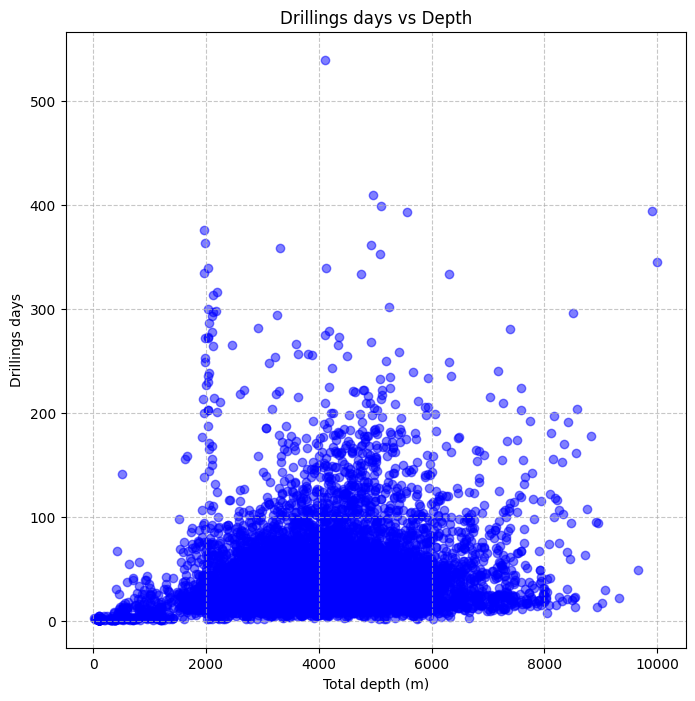

In [32]:
# Filter the wells_data DataFrame to include only rows where 'wlbDrillingDays' is between 0 and 800
wells_data_drilling = wells_data[(wells_data['wlbDrillingDays'] > 0) & (wells_data['wlbDrillingDays'] < 800)]

# Create a scatter plot with a figure size of 8x8 inches
plt.figure(figsize=(8, 8))

# Plot the data: Total Depth on the X-axis and Drilling Days on the Y-axis
plt.scatter(wells_data_drilling['wlbTotalDepth'],  # X-axis: Total Depth
            wells_data_drilling['wlbDrillingDays'],  # Y-axis: Drilling Days
            alpha=0.5,  # Set the transparency of the points
            color='blue')  # Set the color of the points to blue

# Add the axis labels
plt.xlabel('Total depth (m)')  # X-axis label
plt.ylabel('Drillings days')   # Y-axis label

# Add the title of the plot
plt.title('Drillings days vs Depth')

# Add a grid to the plot with dashed lines and some transparency
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()


# Mean of the total depth according to the "Age At Td"

In [33]:
pd.DataFrame(wells_data.groupby('wlbAgeAtTd')['wlbTotalDepth'].mean()).sort_values("wlbAgeAtTd").round(2).head(10)

,wlbTotalDepth
wlbAgeAtTd,
CAMPANIAN,3574.00
CARBONIFEROUS,3368.50
CRETACEOUS,4449.83
DEVONIAN,4438.00
EARLY CARBONIFEROUS,1767.67
EARLY CRETACEOUS,3251.67
EARLY JURASSIC,3631.92
EARLY PERMIAN,3813.61
EARLY TRIASSIC,3081.32


# Volve Field Production Analysis: Monthly Oil, Gas, and Water Trends (NPD Code 7405)

In [34]:
# Create a new 'year_month' column by combining 'Year' and 'Month' columns
# We use 'assign(DAY=1)' to set the day to 1 for all rows, effectively creating a date for the first day of each month
monthly['year_month'] = pd.to_datetime(monthly[['Year', 'Month']].assign(DAY=1))

# Format the 'year_month' column as a string in the 'YYYY-MM' format (e.g., '2024-01')
monthly['year_month'] = monthly['year_month'].dt.strftime('%Y-%m')


In [35]:
monthly

,Wellbore name,NPDCode,Year,Month,On Stream (hrs),Oil (Sm3),Gas (Sm3),Water (Sm3),GI (Sm3),WI (Sm3),year_month
0,15/9-F-1 C,7405,2014,4,227.50000,11142.47,1597936.65,0.00,NaN,NaN,2014-04
1,15/9-F-1 C,7405,2014,5,733.83334,24901.95,3496229.65,783.48,NaN,NaN,2014-05
2,15/9-F-1 C,7405,2014,6,705.91666,19617.76,2886661.69,2068.48,NaN,NaN,2014-06
3,15/9-F-1 C,7405,2014,7,742.41666,15085.68,2249365.75,6243.98,NaN,NaN,2014-07
4,15/9-F-1 C,7405,2014,8,432.99166,6970.43,1048190.80,4529.75,NaN,NaN,2014-08
...,...,...,...,...,...,...,...,...,...,...,...
521,15/9-F-5,5769,2016,5,732.00000,9724.40,1534677.16,3949.90,NaN,0.0,2016-05
522,15/9-F-5,5769,2016,6,718.41667,9121.48,1468557.12,2376.93,NaN,NaN,2016-06
523,15/9-F-5,5769,2016,7,668.64168,9985.29,1602674.39,2453.71,NaN,0.0,2016-07
524,15/9-F-5,5769,2016,8,608.42500,8928.90,1417278.51,2371.86,NaN,0.0,2016-08


This code essentially transforms the Year and Month columns into a single formatted year_month column representing each month in the YYYY-MM format.

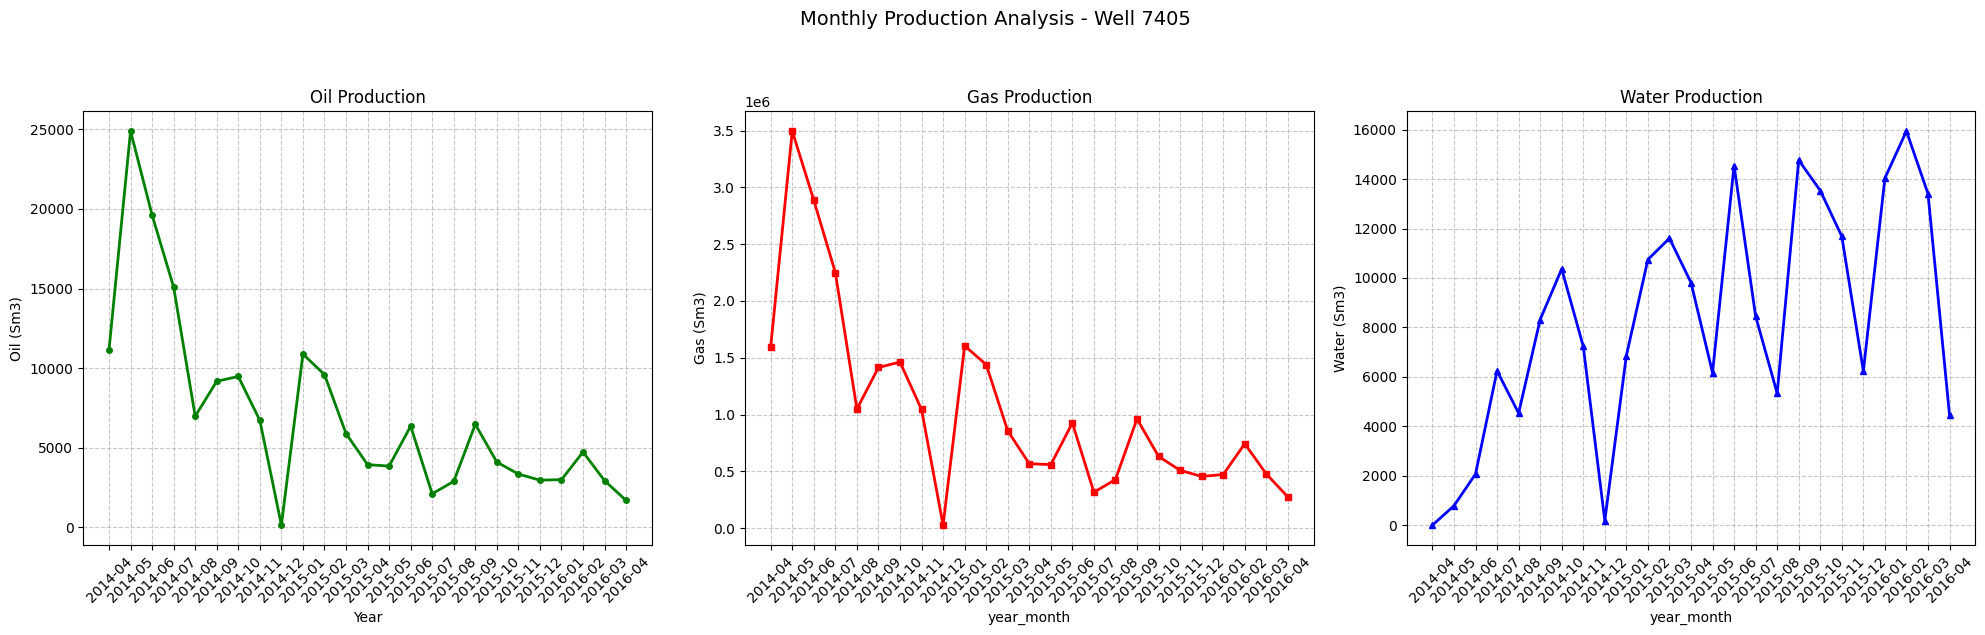

In [ ]:
import matplotlib.pyplot as plt

# Filtrer les données pour NPDCode = 7405
monthly_7405 = monthly[monthly['NPDCode'] == 7405]

# Créer une figure avec trois subplots côte à côte
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Oil Production
ax1.plot(monthly_7405['year_month'], monthly_7405['Oil (Sm3)'],
         marker='o', color='green', linewidth=2, markersize=4)
ax1.set_title('Oil Production', fontsize=12)
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylabel('Oil (Sm3)', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Gas Production
ax2.plot(monthly_7405['year_month'], monthly_7405['Gas (Sm3)'],
         marker='s', color='red', linewidth=2, markersize=4)
ax2.set_title('Gas Production', fontsize=12)
ax2.set_xlabel('year_month', fontsize=10)
ax2.set_ylabel('Gas (Sm3)', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Water Production
ax3.plot(monthly_7405['year_month'], monthly_7405['Water (Sm3)'],
         marker='^', color='blue', linewidth=2, markersize=4)
ax3.set_title('Water Production', fontsize=12)
ax3.set_xlabel('year_month', fontsize=10)
ax3.set_ylabel('Water (Sm3)', fontsize=10)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', rotation=45)

# Titre général
plt.suptitle('Monthly Production Analysis - Well 7405', fontsize=14, y=1.05)

# Ajuster l'espacement
plt.tight_layout()

# Afficher le graphique
plt.show()



In [36]:
# Group the 'monthly' DataFrame by 'Wellbore name' and sum the 'Oil (Sm3)' values for each wellbore
# The result is stored in a new DataFrame 'oil_by_volve'
oil_by_volve = pd.DataFrame(monthly.groupby('Wellbore name')['Oil (Sm3)'].sum()).reset_index()

# Display the resulting DataFrame
oil_by_volve


,Wellbore name,Oil (Sm3)
0,15/9-F-1 C,177709.33
1,15/9-F-11,1147849.10
2,15/9-F-12,4579609.55
3,15/9-F-14,3942233.39
4,15/9-F-15 D,148518.56
5,15/9-F-4,0.00
6,15/9-F-5,41160.68


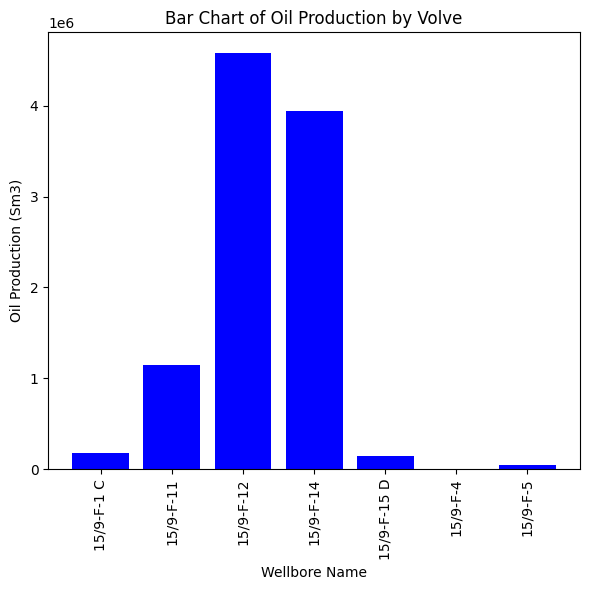

In [37]:
# Create a figure with a size of 6x6 inches
plt.figure(figsize=(6, 6))

# Create a bar chart: 'Wellbore name' on the x-axis and 'Oil (Sm3)' on the y-axis
# The bars will be blue in color
plt.bar(oil_by_volve['Wellbore name'], oil_by_volve['Oil (Sm3)'], color='blue')

# Add the x-axis label
plt.xlabel('Wellbore Name')

# Add the y-axis label
plt.ylabel('Oil Production (Sm3)')

# Add the plot title
plt.title('Bar Chart of Oil Production by Volve')

# Rotate the x-axis labels by 90 degrees for better readability
plt.xticks(rotation=90)

# Adjust the layout to prevent clipping of labels and titles
plt.tight_layout()

# Display the plot
plt.show()




#### Merged Data

In [42]:
# Define the columns to keep from the 'wells_data' DataFrame
cols_to_keep = ['wlbWellboreName', 'wlbTotalDepth']
# Create a new DataFrame 'partial_wells_data' that only includes the selected columns
partial_wells_data = wells_data[cols_to_keep]

# Define the columns to keep from the 'monthly' DataFrame
cols_to_keep1 = ['Wellbore name', 'Oil (Sm3)', 'Gas (Sm3)', 'Water (Sm3)']
# Create a new DataFrame 'partial' with only the selected columns
partial = monthly[cols_to_keep1]

# Group the 'partial' DataFrame by 'Wellbore name' and sum the 'Oil (Sm3)', 'Gas (Sm3)', and 'Water (Sm3)' values for each wellbore
# The result is stored in 'partial_mpd'
partial_mpd = partial.groupby('Wellbore name').sum().reset_index()

# Display the resulting DataFrame with the sum of production data for each wellbore
partial_mpd


,Wellbore name,Oil (Sm3),Gas (Sm3),Water (Sm3)
0,15/9-F-1 C,177709.33,2.644092e+07,207302.39
1,15/9-F-11,1147849.10,1.743105e+08,1090806.27
2,15/9-F-12,4579609.55,6.675423e+08,6833320.37
3,15/9-F-14,3942233.39,5.780095e+08,7121249.74
4,15/9-F-15 D,148518.56,2.250535e+07,52366.40
5,15/9-F-4,0.00,0.000000e+00,0.00
6,15/9-F-5,41160.68,6.561826e+06,13533.18


In [43]:
# Merge the 'partial_wells_data' DataFrame with the 'partial_mpd' DataFrame on the common column 'Wellbore name'
# 'left_on' specifies the column in 'partial_wells_data', and 'right_on' specifies the column in 'partial_mpd'
# Use an inner join ('how='inner') to keep only the rows where the 'Wellbore name' exists in both DataFrames
merged_data = partial_wells_data.merge(
    partial_mpd,
    left_on='wlbWellboreName',  # Column from 'partial_wells_data'
    right_on='Wellbore name',   # Column from 'partial_mpd'
    how='inner'  # Keep only the rows that match in both DataFrames
)

# Display the merged DataFrame
merged_data


,wlbWellboreName,wlbTotalDepth,Wellbore name,Oil (Sm3),Gas (Sm3),Water (Sm3)
0,15/9-F-14,3750.0,15/9-F-14,3942233.39,5.780095e+08,7121249.74
1,15/9-F-12,3520.0,15/9-F-12,4579609.55,6.675423e+08,6833320.37
2,15/9-F-4,3510.0,15/9-F-4,0.00,0.000000e+00,0.00
3,15/9-F-5,3792.0,15/9-F-5,41160.68,6.561826e+06,13533.18
4,15/9-F-11,4562.0,15/9-F-11,1147849.10,1.743105e+08,1090806.27
5,15/9-F-15 D,4685.0,15/9-F-15 D,148518.56,2.250535e+07,52366.40
6,15/9-F-1 C,4094.0,15/9-F-1 C,177709.33,2.644092e+07,207302.39


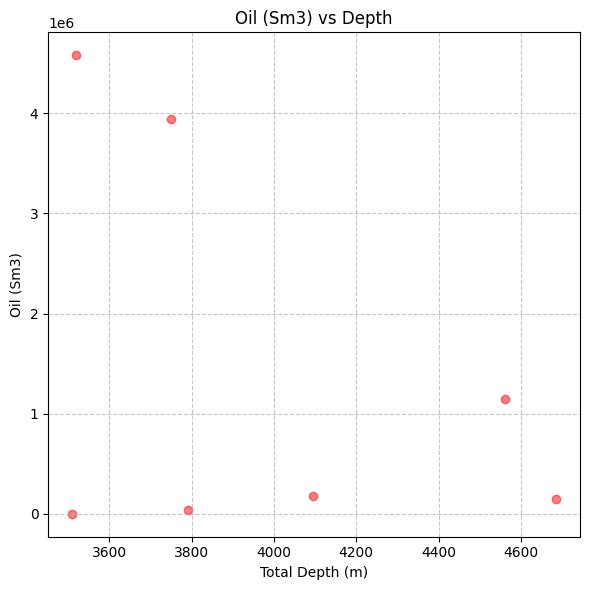

In [45]:
# Create a figure with a single subplot (1 row, 1 column) and a figure size of 6x6 inches
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

# Create a scatter plot on the first axis (ax1)
# Plot 'Total Depth' on the x-axis and 'Oil (Sm3)' on the y-axis
# Set the transparency of the points to 0.5 and color them red
ax1.scatter(merged_data['wlbTotalDepth'],
            merged_data['Oil (Sm3)'],
            alpha=0.5,  # Transparency level of points
            color='red')  # Color of the points

# Set the label for the x-axis
ax1.set_xlabel('Total Depth (m)')

# Set the label for the y-axis
ax1.set_ylabel('Oil (Sm3)')

# Set the title of the plot
ax1.set_title('Oil (Sm3) vs Depth')

# Add a grid with dashed lines and some transparency to make it easier to read the plot
ax1.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout to prevent clipping of labels and titles
plt.tight_layout()

# Display the plot
plt.show()


In [46]:
# value of correlation betweeen  wlbTotalDepth and  Oil (Sm3) in merged_data
merged_data[['wlbTotalDepth','Oil (Sm3)']].corr(method='pearson').iloc[0,1]

-0.4062457634729381

Negative correlation between deepth and oil